# Secular resonance Surface of Section
This notebook demonstrates how to genrate a surface of section on a set of initial conditions with constant ${\cal J}$. We'll set up the surface of section to illustrate a secular resonance around $\Omega_\text{sec}\approx 0$.

## Set-up 
The cells below import the packages and functions we'll need and get an `IntegrableResonanceModel` object

In [22]:
import numpy as np
import sys
sys.path+=['../']
from IntegrableResonanceModel import IntegrableResonanceModel
from IntegrableModelUtils import calc_action_and_frequencies
from scipy.optimize import root_scalar
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#**** Note *******
# Computing accurate secular frequencies can
# require increasing the number of quadrature points
# above the default
res_model = IntegrableResonanceModel(3,1,n_quad_pts=61)

## Generate set of initial condtions with different $\cal J^*$ at constant $\cal J$
We'll start by finding the ${\cal J}$ value that corresponds to the nominal location of secular resonance at a user-specified value of ${\cal J}^*$. The user specifies ${\cal J}^*$ by defining  the corresponding value of eccentricity as $Z_0/Z_{cross}=$ `zf0` . This sets 
$${\cal J}^* = \frac{f^2+g^2}{{\tilde f}^2+{\tilde g}^2}Z_0^2$$
(see Eq. 20). 
The resonance location is found by calculating the secular frequency as a function of intial libration amplitude and using root-finding to locate $\Omega_\text{sec} =0$

In [23]:
zf0 = 0.2 # set 'zf'

_,_,Z = res_model.get_z1z2Z_from_zfrac(zf0) # convert 'zf' to Z

Jstar = res_model.Zsq_to_J * (Z)**2 # convert Z to a value of Jstar

yell = res_model.elliptic_fixed_point(Jstar) # find elliptic point

# Get secular coefficients 
a_s,b_s,c_s = res_model.secular_coeffs()
eps_bs = b_s * res_model.eps

# Calculate initial conditions for a given libration amplitude
calc_ics = lambda librationAmplitude:  yell + np.array([librationAmplitude,0,0,0])

# Calculate the secular frequency as a function of libration amplitude
calc_Omega_sec = lambda librationAmplitude: eps_bs + calc_action_and_frequencies(
    calc_ics(librationAmplitude),
    res_model)[2]

# FInd libration amplitude where Omega_sec = 0 
root = root_scalar(calc_Omega_sec,bracket=[2.,2.9])

In [24]:
ics = yell + np.array([root.root,0,0,0])
action0,_,_=calc_action_and_frequencies(ics,res_model)

Now we'll find initial conditions with different values of ${\cal J}^*$ and the same value of ${\cal J}=$`action0`

In [25]:
# 'zf_min' and 'zf_max' define the range of 
# J_star values over which to generate initial conditions
zf_min,zf_max = 0.15,0.25

zfs = np.linspace(zf_min,zf_max,10)

ics = []

for zf in zfs:
    _,_,Z = res_model.get_z1z2Z_from_zfrac(zf)
    Jstar = res_model.Zsq_to_J * (Z)**2
    yell = res_model.elliptic_fixed_point(Jstar)
    
    # Calculate initial conditions for a given libration amplitude
    calc_ics = lambda librationAmplitude:  yell + np.array([librationAmplitude,0,0,0])
    
    # Calculate value of action as function of libration amplitude
    calc_action = lambda librationAmplitude: calc_action_and_frequencies(calc_ics(librationAmplitude),res_model)[0]
    
    # Calculate difference from target value of action as function of libration amplitude
    calc_delta_action = lambda librationAmplitude: calc_action(librationAmplitude)-action0
    try:
        root = root_scalar(calc_delta_action,bracket=[1.,3])
    except ValueError:
        print("Failed for zf ={:.2f}. Try changing the bracketing values for the root.".format(zf))
        break
    if root.converged:
        ics.append(calc_ics(root.root))

ics = np.array(ics)

A quick look at the set of initial conditions we've generated

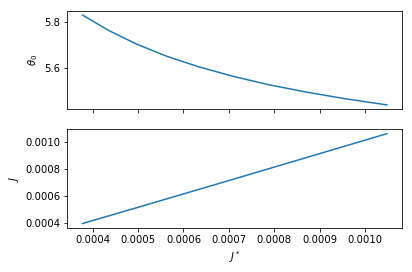

In [26]:
fig,ax = plt.subplots(2,sharex=True)
ax[0].plot(ics[:,3] , ics[:,0])
ax[1].plot(ics[:,3] , ics[:,2])
ax[0].set_ylabel(r"$\theta_0$")
ax[1].set_ylabel(r"$J$")
ax[1].set_xlabel(r"$J^*$")

We'll interpolate our results above to get intial conditions at constant ${\cal J}$ as a functions of ${\cal J}^*$

In [27]:
from scipy.interpolate import CubicSpline
ics_vs_zfrac = CubicSpline(zfs,ics)

#  Creating the surface of section 

Our surface of section will consist of contours of constant total energy, $E = H_0 + H_\text{pert}$ as a function of variables $({Z_0}/Z_\text{cross},\theta+\theta^*)$ with ${\cal J}=$`action0` held fixed.
We'll also specify a value for the conserved quantity ${\cal A}$ which is essentially the libration-averaged AMD of the planet pair. The value of ${\cal A}$ determines the magnitude $H_\text{pert}$ and therefore sets the size of the secular resoance.

In order to create the surface of section we'll create a compiled function to compute

$$
H_\text{pert}(J,\theta,J^*,\theta^*)= \epsilon b_s J^* -\epsilon c_s\sqrt{J({\cal A} - J^*)}\cos(\theta+\theta^*)
$$



In [28]:
import theano
import theano.tensor as T

dyvars = T.vector()
calA,b_s,c_s,eps = T.dscalars(4)
theta,theta_star,J,J_star = [dyvars[i] for i in range(4)]
_Fpert = eps * b_s * J_star -  eps * c_s * T.sqrt(J) * T.sqrt(calA - J_star)  * T.cos(theta+theta_star)
Fpert = theano.function(
    inputs=[dyvars,calA,b_s,c_s,eps],
    outputs=_Fpert
   )
gradFpert = theano.function(
    inputs=[dyvars,calA,b_s,c_s,eps],
    outputs=theano.grad(_Fpert,wrt=dyvars)
   )
hessFpert = theano.function(
    inputs=[dyvars,calA,b_s,c_s,eps],
    outputs=theano.gradient.hessian(_Fpert,wrt=dyvars)
   )

In [29]:
# Set calA as a multiple of J^*.
# Note that calA *must* be greater than or equal to J^*
calA = 2 * ics_vs_zfrac(zf0)[3]
_,b_s,c_s = res_model.secular_coeffs()

# set up grid
Ngrid = 50
Energy = np.zeros((Ngrid,Ngrid))
zfs = np.linspace(zf_min,zf_max,Ngrid)
theta_plus_thetastars = np.linspace(-np.pi,np.pi,Ngrid)
# loop over grid
for i,zf in enumerate(zfs):
    for j,theta_plus_thetastar in enumerate(theta_plus_thetastars):
        y = ics_vs_zfrac(zf)
        y[1] = theta_plus_thetastar - y[0]
        Energy[i,j] = res_model.H(y)+Fpert(y,calA,b_s,c_s,res_model.eps)


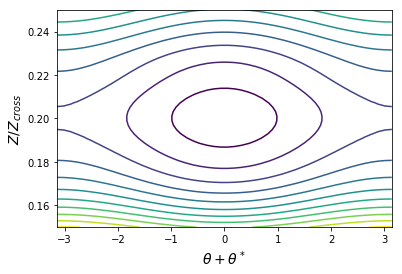

In [32]:
X,Y = np.meshgrid(theta_plus_thetastars,zfs)
plt.contour(X,Y,Energy,10)
plt.xlabel(r"$\theta+\theta^*$",fontsize=14)
plt.ylabel(r"$Z/Z_{cross}$",fontsize=14)


# Compare to $N$-body
  Let's run a few $N$-body simulations to compare with our surface of section.

In [37]:
# Initial Z0/Zcross values to use
Nb_zfs = [0.17,0.2,0.23]
# Initial theta+theta_star value to use
initial_theta_plus_theta_star = 2

# Lists to store rebound simlutions and 
# intial values of energy to identify the 
# contours on our surface of section corresponding 
# to the simulations
sims = []
Energies = []

# Set up sims
for zf in Nb_zfs:
    y = ics_vs_zfrac(zf)
    y[1] = initial_theta_plus_theta_star - y[0]
    Energies.append(res_model.H(y)+Fpert(y,calA,b_s,c_s,res_model.eps))
    sims.append(res_model.dyvars_to_rebound_sim(y,calA = calA,P2 = 2*np.pi))

In [38]:
# Integration times
time = np.linspace(0,2e4 * sims[0].particles[2].P,150)

In [41]:
# Run integrations, store orbital elements
els = np.zeros((len(sims),len(time),2,4))
for i,t in enumerate(time):
    for k,sim in enumerate(sims):
        sim.integrate(t)
        for j,p in enumerate(sim.particles[1:]):
            els[k,i,j] = p.P,p.e,p.l,p.pomega

(0.15, 0.25)

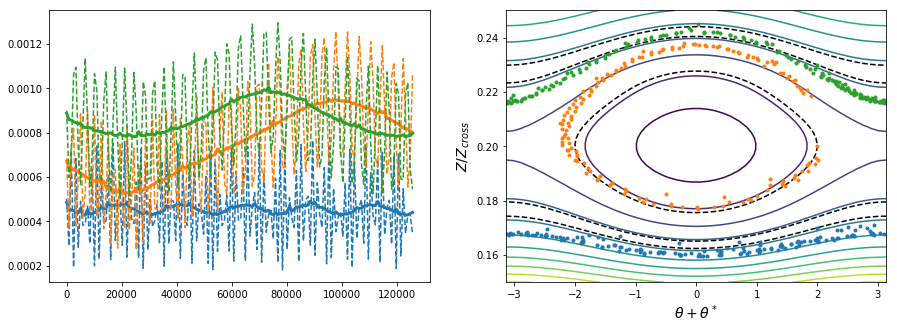

In [44]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
_,_,Zcross = res_model.get_z1z2Z_from_zfrac(1)
X,Y = np.meshgrid(theta_plus_thetastars,zfs)
ax[1].contour(X,Y,Energy,10)
ax[1].contour(X,Y,Energy,np.sort(Energies),colors=['k'],linestyles=['-'],linewidths=[3])
for k in range(len(sims)):
    z1,z2 = np.transpose(els[k,:,:,1] * np.exp(1j * els[k,:,:,3]))

    Mmtrx = res_model._get_M_matrix()

    rtPhi_exp_iphi,rtPsi_exp_ipsi = np.conjugate(np.linalg.inv(Mmtrx).dot([z1,z2]))

    J = np.abs(rtPhi_exp_iphi)**2

    l1,l2=np.transpose(els[k,:,:,2])

    P1,P2=np.transpose(els[k,:,:,0])

    Delta = (res_model.j - res_model.k) * P2 / P1 / res_model.j - 1

    Jstar = J-Delta / res_model.dJ_to_Delta

    Q = res_model.j * l2 - (res_model.j-res_model.k) * l1

    theta = (Q + res_model.k * np.angle(rtPhi_exp_iphi)) / res_model.k
    thetaStar = -1 * (Q + res_model.k * np.angle(rtPsi_exp_ipsi)) / res_model.k
    
    # Plot Jstar and J versus time
    line,=ax[0].plot(time,Jstar,lw = 3)
    ax[0].plot(time,J,'--',color=line.get_color())
    
    # Plot Z_0 / Zcross versus theta+thetaStar on the surface of section plot
    Z0_over_Zcross = np.sqrt(Jstar/res_model.Zsq_to_J)/Zcross
    ang = np.mod(theta+thetaStar+np.pi,2*np.pi)-np.pi
    ax[1].plot(ang,Z0_over_Zcross,'.',color=line.get_color())
    
ax[1].set_xlabel(r"$\theta+\theta^*$",fontsize=14)
ax[1].set_ylabel(r"$Z/Z_{cross}$",fontsize=14)
ax[1].set_ylim(ymax = 0.25)


Pretty good agreement! Though there does appear to be a small shift in the resonance center relative to the prediction. This could be the result of at least a couple effects:
- We've Truncated the secular Hamiltonian at second order in eccentricities.
- We should really have chosen ICs for constant $\bar{ {\cal J}} = {\cal J} + \frac{\partial W}{\partial \zeta}$ where $W$ is a generating function that satisfies $$\sum_{i=1}^{2}\Omega_i\frac{\partial W(\zeta_i,{\cal J}_i)}{\partial\zeta_i} =H_\text{pert}(\zeta_i,{\cal J}_i) - \frac{1}{2\pi}\int_{0}^{2\pi} H_\text{pert}(\zeta_i,{\cal J}_i) d\zeta$$
(See <a href=https://ui.adsabs.harvard.edu/abs/1990CeMDA..49...43H/abstract>Henrard (1990)</a> for details). <a href=https://ui.adsabs.harvard.edu/abs/1990CeMDA..49...43H/abstract>Henrard (1990)</a> provides a method for computing $\bar{ {\cal J}}$ semi-numerically-- I'll leave it as an exercise :).